In [ ]:
import numpy as np
import networkx as nx
from deepwalk import DeepWalk


adj_matrices = np.load('distanceMatrices.npy')  
graph_embeddings = []
count = 0

for adj_matrix in adj_matrices:
    
    print(count)
    count += 1
    
    graph = nx.from_numpy_array(adj_matrix)

    model = DeepWalk(walk_length=30, num_walks=30, workers=4)
    model.fit(graph)

    embeddings = [model[str(node)] for node in graph.nodes()]

    mean_embedding = np.mean(embeddings, axis=0)
    std_embedding = np.std(embeddings, axis=0)
    concat_embedding = np.concatenate([mean_embedding, std_embedding])
    graph_embeddings.append(concat_embedding)


graph_embeddings = np.array(graph_embeddings)


np.save('graph_embeddings_std.npy', graph_embeddings)


In [ ]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

graph_embeddings = np.load('graph_embeddings_std.npy') 

scaler = StandardScaler()
graph_embeddings_scaled = scaler.fit_transform(graph_embeddings)

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1)

graph_embeddings_2d = kpca.fit_transform(graph_embeddings_scaled)

np.save('graph_embeddings_2d_std_kpca.npy', graph_embeddings_2d)


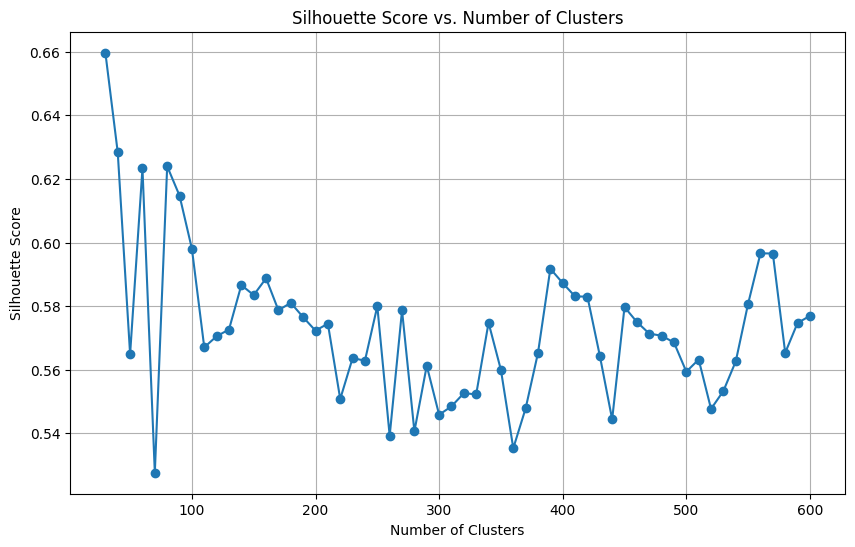

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


graph_embeddings_2d = np.load('graph_embeddings_2d_std_kpca.npy')  

cluster_range = range(30, 601, 10)

silhouette_scores = []

for num_clusters in cluster_range:

    gmm = GaussianMixture(n_components=num_clusters, random_state=42)

    cluster_labels = gmm.fit_predict(graph_embeddings_2d)

    silhouette_avg = silhouette_score(graph_embeddings_2d, cluster_labels)
    
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


Silhouette Score for 80 clusters: 0.6239836


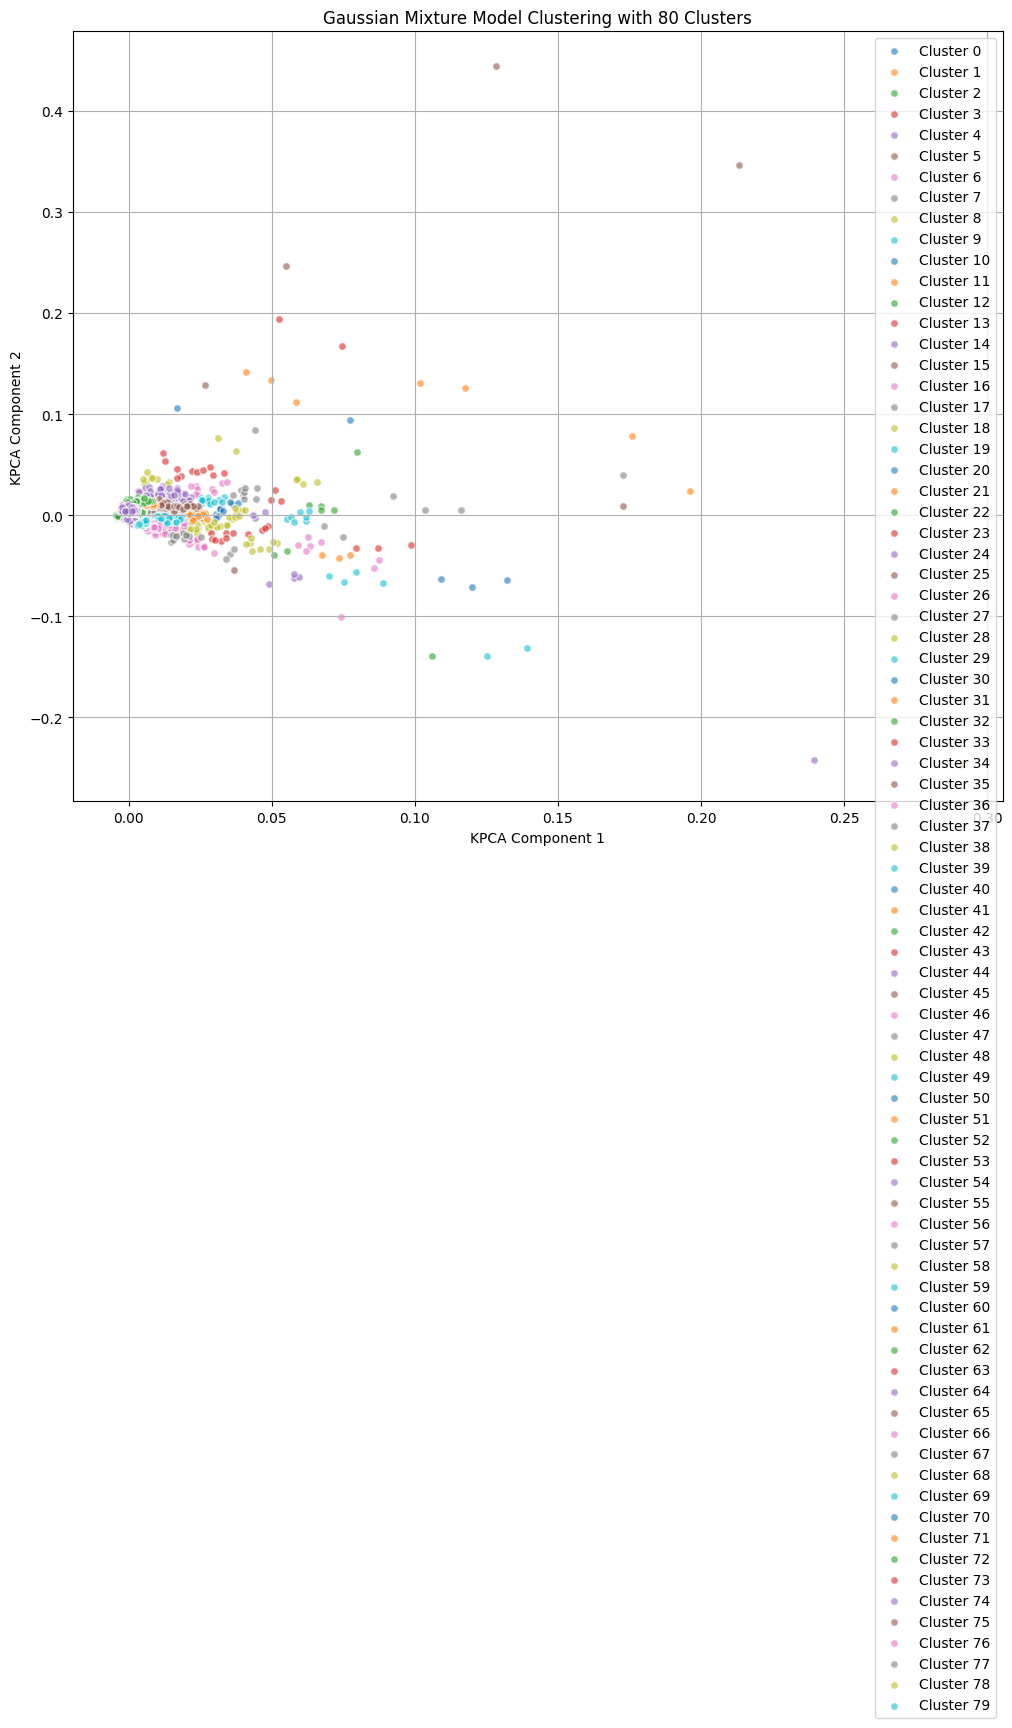

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

graph_embeddings_2d = np.load('graph_embeddings_2d_std_kpca.npy')  # Shape: (6001, 2)

num_clusters = 80

gmm = GaussianMixture(n_components=num_clusters, random_state=42)
cluster_labels = gmm.fit_predict(graph_embeddings_2d)

silhouette_avg = silhouette_score(graph_embeddings_2d, cluster_labels)
print("Silhouette Score for 80 clusters:", silhouette_avg)

# Save cluster labels to an npy file
np.save('cluster_labels_80.npy', cluster_labels)

plt.figure(figsize=(12, 10))
for cluster in range(num_clusters):
    cluster_points = graph_embeddings_2d[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6, edgecolors='w', s=30)

plt.title(f'Gaussian Mixture Model Clustering with {num_clusters} Clusters')
plt.xlabel('KPCA Component 1')
plt.ylabel('KPCA Component 2')
plt.grid(True)
plt.legend()
plt.show()


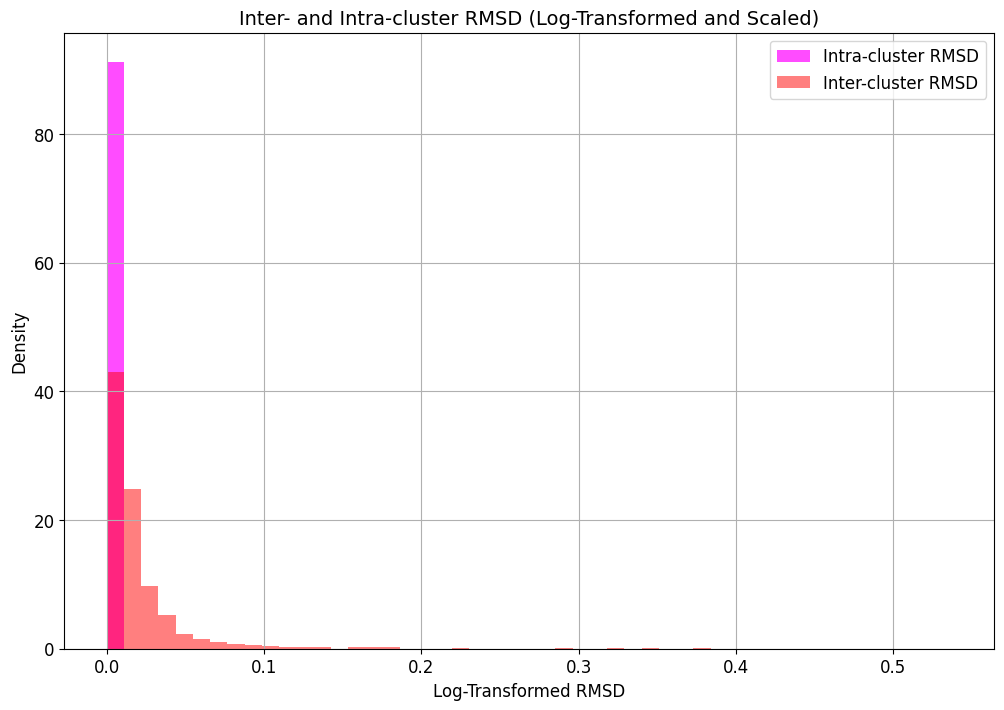

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist

# Load the graph embeddings and cluster labels
graph_embeddings_2d = np.load('graph_embeddings_2d_std_kpca.npy')  # Shape: (6001, 2)
cluster_labels = np.load('cluster_labels_80.npy')  # Assuming you have cluster labels for each embedding

# Initialize lists to store intra and inter-cluster RMSD values
intra_cluster_rmsd = []
inter_cluster_rmsd = []

# Compute RMSD values
unique_clusters = np.unique(cluster_labels)
for cluster in unique_clusters:
    # Extract embeddings belonging to the current cluster
    cluster_points = graph_embeddings_2d[cluster_labels == cluster]
    
    # Compute pairwise distances within the cluster
    if len(cluster_points) > 1:
        intra_distances = pdist(cluster_points, metric='euclidean')
        intra_cluster_rmsd.extend(intra_distances)
    
    # Compute inter-cluster RMSD with other clusters
    for other_cluster in unique_clusters:
        if other_cluster != cluster:
            other_cluster_points = graph_embeddings_2d[cluster_labels == other_cluster]
            inter_distances = cdist(cluster_points, other_cluster_points, metric='euclidean')
            inter_cluster_rmsd.extend(inter_distances.flatten())

# Convert lists to numpy arrays for easier manipulation
intra_cluster_rmsd = np.array(intra_cluster_rmsd)
inter_cluster_rmsd = np.array(inter_cluster_rmsd)

# Apply logarithmic transformation to RMSD values
log_intra_cluster_rmsd = np.log1p(intra_cluster_rmsd)  # log1p to handle zero values
log_inter_cluster_rmsd = np.log1p(inter_cluster_rmsd)

# Define the number of bins for the histograms
bins = np.linspace(0, max(log_inter_cluster_rmsd.max(), log_intra_cluster_rmsd.max()), 50)

# Plot histograms
plt.figure(figsize=(12, 8))

# Plot intra-cluster histogram
plt.hist(log_intra_cluster_rmsd, bins=bins, color='magenta', alpha=0.7, label='Intra-cluster RMSD', density=True)

# Plot inter-cluster histogram
plt.hist(log_inter_cluster_rmsd, bins=bins, color='red', alpha=0.5, label='Inter-cluster RMSD', density=True)

# Adjusting the y-ticks for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  # Removing specific values for more flexibility

plt.title('Inter- and Intra-cluster RMSD (Log-Transformed and Scaled)', fontsize=14)
plt.xlabel('Log-Transformed RMSD', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()


In [15]:
import numpy as np

# Load cluster labels
cluster_labels = np.load('cluster_labels_80.npy')

# Initialize a dictionary to store the count of graphs in each cluster
cluster_counts = {}

# Count the number of graphs in each cluster
for cluster in np.unique(cluster_labels):
    cluster_counts[cluster] = np.sum(cluster_labels == cluster)

# Save the cluster counts to a text file
with open('cluster_counts.txt', 'w') as file:
    for cluster, count in cluster_counts.items():
        file.write(f'Cluster {cluster}: {count} graphs\n')

print("Cluster counts saved to 'cluster_counts.txt' file.")


Cluster counts saved to 'cluster_counts.txt' file.
